# Colisiones 2D

Este programa esta implementado para simular la interacción que se presenta entre particulas solidas contenidas en un espacio finito

Importamos las librerias que vamos a utilizar para poder llevar a cabo la animación

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim

Definimos la clase que se encarga de asignar los atributos y definir los metodos a partir de los cuales se va a resolver el problema de interacción entre las particulas

In [145]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        self.dt  = t[1] - t[0]
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
    # Method
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
    
        # Euler method
        self.r += self.dt * self.v
        self.v += self.dt * self.a
            
    def CheckWallLimits(self,limits,dim=2):
        
        for i in range(dim):
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = - self.v[i]
                
    def ReduceSizevelocity(self,factor):
        
        self.RvVector = np.array([self.vVector[0]]) # initial condition
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
        
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
    # Setters
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    # Getters  
    def GetPositionVector(self):
        return self.rVector

    def GetRPositionVector(self):
        return self.RrVector
    
    def GetVelocityVector(self):
        return self.vVector
    def GetRVelocityVector(self):
        return self.RvVector
    def GetR(self):
        return self.radius

Definimos una función que se encarga de generar las particulas que vamos a simular

In [146]:
def GetindividualParticle(position, velocity, aceleration, t):

    x0 = position
    v0 = velocity
    a0 = aceleration
        
    p = Particle(x0,v0,a0,t,1.,1.0,1)
        
    return p

In [158]:
#Discretización del tiempo 

dt = 0.001
tmax = 30
tiempo = np.arange(0,tmax+dt,dt)

In [167]:
esferas_solidas = []
posiciones_iniciales = np.array([[1.,1.], [0.,-1.6], [-15., -15.]])
velocidades_iniciales = np.array([[20.,0.], [0.,0.], [0.,0.]])
aceleraciones_iniciales = np.array([[0.,0.],[0.,0.],[0.,0.]])

for i in range(len(posiciones_iniciales)):
    particle = GetindividualParticle(posiciones_iniciales[i], velocidades_iniciales[i], aceleraciones_iniciales[i], tiempo)
    esferas_solidas.append(particle)
print(esferas_solidas)

[1. 1.]


In [160]:
def RunSimulationP(t,P, Limits):
    
    for it in tqdm(range(len(t))): # Evolucion temporal
        P.CheckWallLimits(Limits)
        P.Evolution(it)
    return P

In [161]:
Limits = np.array([20.,20.])

In [162]:
p1 = RunSimulationP(tiempo,esferas_solidas[0], Limits)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 30001/30001 [00:00<00:00, 103716.07it/s]


In [163]:
print(esferas_solidas[0].GetPositionVector())

[[  1.     1.  ]
 [  1.02   1.  ]
 [  1.04   1.  ]
 ...
 [600.96   1.  ]
 [600.98   1.  ]
 [601.     1.  ]]


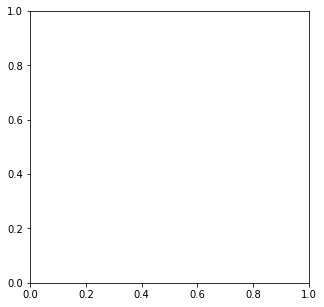

In [164]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)


def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(tiempo[i]), fontsize=15)
    for particle in esferas_solidas:
        print("Holi")
        x = particle.GetPositionVector()[i,0]
   
        y = particle.GetPositionVector()[i,1]
        
    #vx = P.GetVelocityVector()[i,0]
    #vy = P.GetVelocityVector()[i,1]
        
        circle = plt.Circle((x,y), particle.GetR(), color='k', fill=False )
        plot = ax.add_patch(circle)
        #plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)

    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(tiempo),init_func=init)